# Intro

This module is based on a Pluralsight course, Understanding and Applying Financial Risk Modeling Techniques (https://app.pluralsight.com/library/courses/financial-risk-modeling-techniques/table-of-contents), with this part Implementing Financial Risk Models in Python.

The code itself is nearly verbatim, but again, this is mostly for my own development, working through the peculiarities of Value at Risk (VaR) in both R and Python.

The general outline of this process is as follows:

- Load and clean Data
- Calculate returns
- Calculate historical variance
- Calculate systemic, idiosyncratic, and total variance
- Develop a range of stress variants, e.g. scenario-based possibilities
- Calculate VaR, as the worst case loss in a period for a particular probability

Note, The data required for this is in my Public Google Drive folder: https://drive.google.com/folderview?id=0B5Mi6_CV6da5aFc2Q0g3cHowVms&usp=sharing.

# Load and Clean Data

In [2]:

# load data
filePath <- "Portfolios.csv"
portfolios.dirty <- read.table(filePath, header = TRUE, sep = ",", stringsAsFactors = FALSE)

# convert date: http://www.statmethods.net/input/dates.html
portfolios.dirty[, c("AsOfDate")] <- as.Date(portfolios.dirty[, c("AsOfDate")], "%m/%d/%Y")

# sort by date: # http://www.statmethods.net/management/sorting.html
portfolios.sorted <- portfolios.dirty[order(portfolios.dirty$AsOfDate, decreasing = TRUE),]
head(portfolios.sorted)

# remove nulls
# NA in this module


AsOfDate,AAPL,ADBE,CVX,GOOG,IBM,MDLZ,MSFT,NFLX,ORCL,SBUX,FVX,SP500
2017-01-03,121.1049,113.82,110.7598,823.83,174.4209,44.43000,64.73753,141.22,40.23000,55.64924,1.936,2280.90
2016-12-01,115.3200,102.95,116.5841,792.45,164.6878,44.33000,61.76555,123.80,38.30000,55.27094,1.934,2238.83
2016-11-01,110.0429,102.81,110.5023,775.88,160.9474,41.06603,59.89687,117.00,40.03321,57.70995,1.834,2198.81
2016-10-03,112.4724,107.51,102.7284,809.90,151.1134,44.75042,59.15927,124.87,38.27011,52.58833,1.313,2126.15
2016-09-01,111.9870,108.54,100.9337,804.06,156.1869,43.71481,56.86872,98.55,38.97577,53.64862,1.156,2168.27
2016-08-01,105.1024,102.31,98.6389,789.85,156.2164,44.63273,56.73050,97.45,40.90075,55.71965,1.180,2170.95


# Estimating Historical Risk

## Calculating Returns

In [3]:

# copy data frame, preserving original
returns <- portfolios.sorted

# calculate returns as difference between rows
returns[-nrow(returns), -1] <- returns[-nrow(returns), -1] / returns[-1, -1] - 1

# removes last row, since it is not a calcualted return
returns <- returns[-nrow(returns),]

# create a data frame of stock names, not the date and not the factors to use as a filter
stockNames = names(returns)[-which(names(returns) %in% c('AsOfDate', 'FVX', 'SP500'))]

# create a data frame of only stocks
stockReturns <- returns[stockNames]


## Historical Risk

In [4]:

# create a data frame of weights, but make it equal weighted
# it is therefore 1 for each item, divided by the number of names
# in effect, 1 divided by 10
weights <- data.frame(rep(1, times = length(stockNames)) / length(stockNames))

# rename the row names, then rename the column header
row.names(weights) <- stockNames
names(weights) <- "Weights"

# cacluate portfolio variance
# Var(p) = W * COV(Y) * W_transposed
# matrix multiplication is done via %*%
# first is transpose of weights
# second is the covariance of the returns
# third is the matrix of weights
(historicalReturnRisk <- t(weights) %*% cov(stockReturns) %*% as.matrix(weights))


,Weights
Weights,0.002651255


# Building Factor Models

In [5]:

# calculate lm (regression) for FVX, SP500, and the stock value
# loops for each stock to create
# create data frame
modelCoeffs <- data.frame()
for (stockName in stockNames) {
    stockReturn <- as.matrix(returns[stockName])
    sp500 <- as.matrix(returns["SP500"])
    fvx <- as.matrix(returns["FVX"])
    model <- lm(stockReturn ~ sp500 + fvx)
    modelCoeffs <- rbind(modelCoeffs, cbind(coef(model)[1], coef(model)[2], coef(model)[3], sd(resid(model))))
}

# cleanup data frame
row.names(modelCoeffs) <- stockNames
names(modelCoeffs) <- c("Alpha","B_SP500","B_FVX","ResidualVol")
modelCoeffs


,Alpha,B_SP500,B_FVX,ResidualVol
AAPL,0.018664916,1.1991191,2.561065e-05,0.07516934
ADBE,0.005644976,1.4243920,2.994288e-02,0.05574671
CVX,0.004126261,0.8364382,2.618645e-02,0.04527437
GOOG,0.008247275,1.0198370,5.462373e-02,0.06884065
IBM,0.004701382,0.6658580,4.555355e-02,0.04351037
MDLZ,0.006146202,0.6724939,-3.606942e-02,0.04656505
MSFT,0.005910928,0.9885443,3.978635e-02,0.05606596
NFLX,0.042231995,0.8291986,-3.795474e-02,0.17145042
ORCL,0.004897424,1.0655340,3.162929e-02,0.04775447
SBUX,0.008555770,1.0871140,1.535477e-02,0.06516606


# Idiosyncratic and Systemic Risk

Besides historical risk, one can decompose risk into systemic (beta) and idiosyncratic risk (alpha), the latte rbeing specific to the stock itself:

TotalVaR(P) = SystemicVaR(P) + IdisyncraticVaR(P)

In [6]:

# systemicVariance(P) = weights * betas * covariance(factor returns) * betas_transposed * weight_transposed
# create matrix of factors
factorNames <- c("SP500","FVX")
factorReturns <- returns[factorNames]

# internal covariance matrix
reconstructedCov <- as.matrix(modelCoeffs[c("B_SP500", "B_FVX")]) %*% as.matrix(cov(factorReturns)) %*% t(modelCoeffs[c("B_SP500", "B_FVX")])

# external covariance matrix
systemicVariance <- t(weights) %*% reconstructedCov %*% as.matrix(weights)


# idosyncraticVariance(P) = weights * var(residuals) * weight_transposed
idosyncraticVariance <- sum((weights ^ 2) * (modelCoeffs$ResidualVol ^ 2))


# totalVariance = systemicVariance + idiosyncraticVariance
(factorBasedVariance = systemicVariance + idosyncraticVariance)


,Weights
Weights,0.002519483


# Scenario-based Stress Testing

In [7]:

# create a range of scenarios, stepping from min to max through the factors, FVX and S&P500
fvxScenarios <- seq(min(returns["FVX"]), max(returns["FVX"]), by = .05)
sp500Scenarios <- seq(min(returns["SP500"]), max(returns["SP500"]), by = .02)

# build scenarios from fvxScenarios by sp500Scenarios
scenarios <- data.frame()
for (fvxValue in fvxScenarios) {
    for (sp500value in sp500Scenarios) {
        scenario <- cbind(fvxValue, sp500value)
        scenarioPredictedReturns <- data.frame()
        for (stockName in stockNames) {
            alpha = subset(modelCoeffs, row.names(modelCoeffs) %in% c(stockName)) ["Alpha"]
            beta_sp = subset(modelCoeffs, row.names(modelCoeffs) %in% c(stockName))["B_SP500"]
            beta_fvx = subset(modelCoeffs, row.names(modelCoeffs) %in% c(stockName))["B_FVX"]
            scenarioPredictedReturn = alpha + (beta_sp * sp500value) + (beta_fvx * fvxValue)
            scenarioPredictedReturns = rbind(scenarioPredictedReturns, scenarioPredictedReturn)
        }
        scenario <- (cbind(scenario, t(scenarioPredictedReturns)))
        scenarios <- rbind(scenarios, scenario)
    }
}

# totalVariance(P) = weights * cov(scenarios) * weight_transposed
(scenarioTotalVariance <- t(weights) %*% cov(as.matrix(scenarios[stockNames]))  %*% as.matrix(weights))


,Weights
Weights,0.006272121


# Quantifying the Worst Case

In [8]:

# VaR = P x Z_alpha x stdDev
calculateVaR <- function(risk, confidenceLevel, principal = 1, numMonths = 1) {
    vol <- sqrt(risk)
    data.frame(VaR = abs(principal * qnorm(1-confidenceLevel, 0, 1) * vol * sqrt(numMonths))[1])
}

# Worst Case: VaR based on scenario-based stress testing
calculateVaR(scenarioTotalVariance, 0.99)

# Allternaitve Risk Measure:  VaR based on factors
calculateVaR(factorBasedVariance, 0.99)

# Allternaitve Risk Measure:  VaR based on history
calculateVaR(historicalReturnRisk, 0.99)


VaR
0.1842391


VaR
0.1167698


VaR
0.1197844


# Plotting VaR

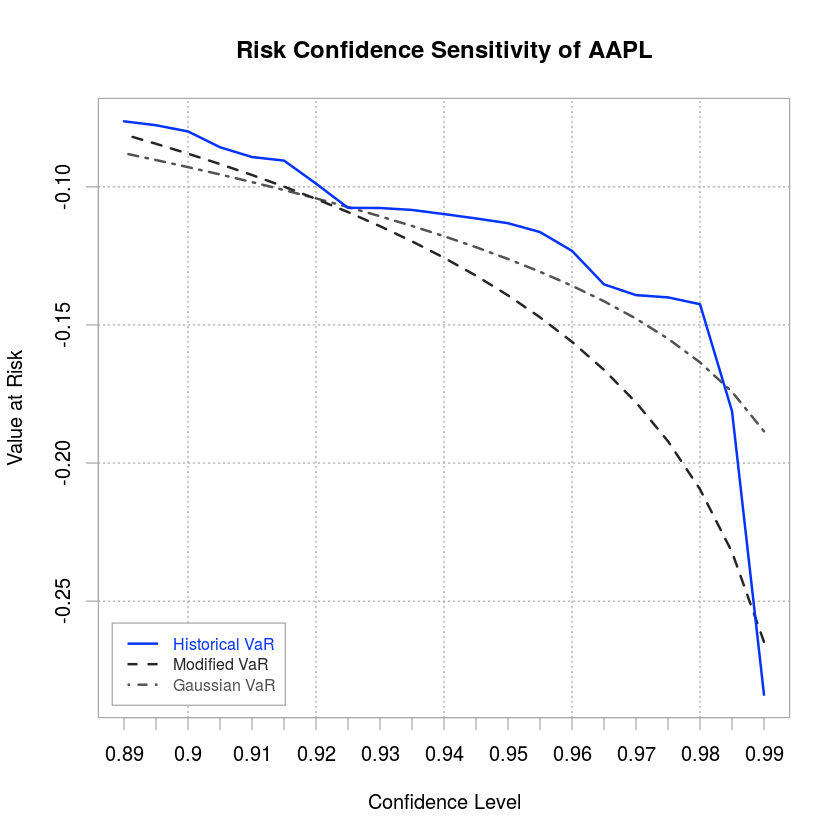

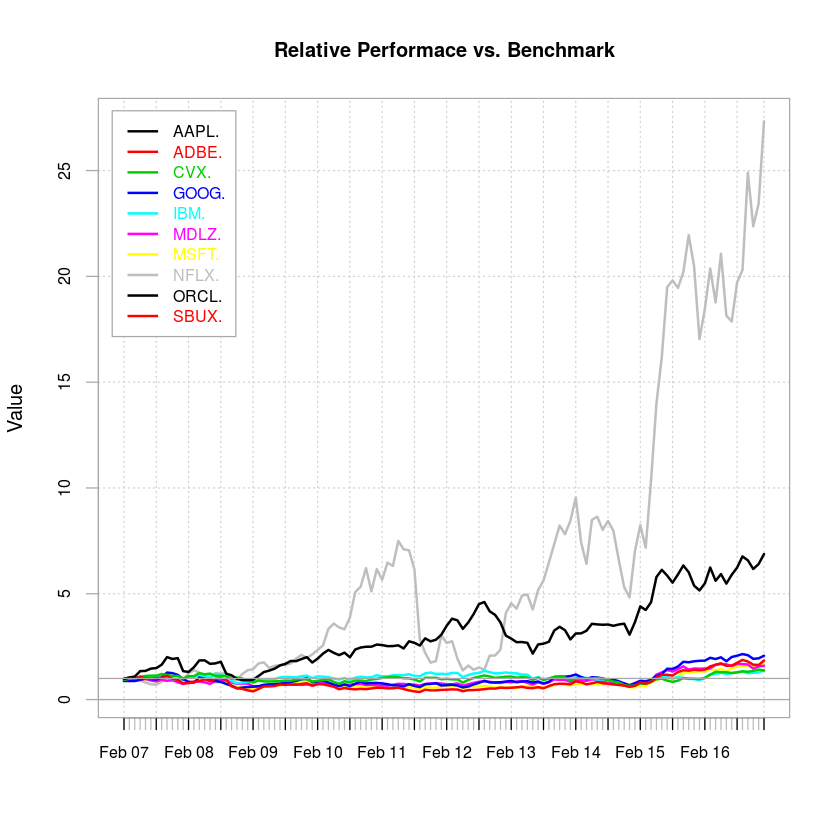

In [10]:
library(PerformanceAnalytics)

returnsForChart <- returns

row.names(returnsForChart) <- c(returnsForChart$AsOfDate)

chart.VaRSensitivity(returnsForChart[, 2:11, drop=TRUE],
		methods=c("HistoricalVaR", "ModifiedVaR", "GaussianVaR"),
		colorset=bluefocus, lwd=2)

chart.RelativePerformance(returnsForChart[, 2:11], returnsForChart[, 13], main = "Relative Performace vs. Benchmark",
    colorset = c(1:8), xaxis = TRUE, ylog = FALSE, legend.loc = "topleft", cex.legend = 0.8)